In [1]:
# Loading in data

import os
import sys
import math
import random

import csv
import pandas as pd
import numpy as np
from numpy import random

from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from cycler import cycler

# Note: matrix.shape[0] is number of rows, matrix.shape[1] is number of columns

# Current working directory
#currdir = os.path.dirname(os.path.realpath(__file__)) # doesn't work in Jupyter Notebook
currdir = "/Users/jshih7/Desktop/2017-2018/machine_learning/Makeene Learning/proj3"

# Data set that Keene asked us to generate in class
def getKeeneData(N1, N2):
    
    # Total number of observations
    N = N1+N2;

    # Parameters for Gaussian (these are unknown and we're to estimate them)
    mu1 = np.array([1,1])
    mu2 = np.array([-1,-1])
    cov = np.array([[1,0],[0,1]]) # or do identity

    # Generate data samples from Gaussian
    # Samples are nObservations-by-nFeatures
    X1 = np.random.multivariate_normal(mu1,cov,N1)
    X2 = np.random.multivariate_normal(mu2,cov,N2)                               
    X = np.concatenate((X1,X2),axis=0)
        # concatenate data into one matrix
    Y = np.concatenate(( np.ones((X1.shape[0],1)), \
                        np.zeros((X2.shape[0],1)) ),axis=0)
        # generate column vector for corresponding values (we want to predict these)

    # Convert data to matrices for simpler Python operations
    X = np.asmatrix(X)
    Y = np.asmatrix(Y)
    
    return (X,Y)

# Two features, a and b
# Label is whether or not a > b
def getRandomData(nSamples):
    
    nFeatures = 2
    X = np.asmatrix(np.random.rand(nSamples,nFeatures))
        # generate random matrix of features
        # need to cast to matrix because it's originally of type ndarray
    Y = np.greater(X[:,0],X[:,1]).astype(int)
        # generate labels by comparing feature columns
        # cast from bool to int so you can do arithmetic
    
    return(X,Y)

# Load CSV file and return separate matrices for features and labels
# Include optional flags to do normalization and balancing of data, default off
# File names we're using: "/pid.data" and "/haberman.data"
def getDataMatrix(filename,balanceOn=False,normalizeOn=False):

    # Load file in numpy matrix
    pathname = currdir + filename
    data_mat = np.loadtxt(open(pathname,"rb"),delimiter=",")
    data_mat = np.asmatrix(data_mat) # as before, cast from ndarray to matrix
    
    # Ensure label values are 1's and 0's
    Y_tmp = data_mat[:,data_mat.shape[1]-1:] 
        # get last column of data for labels
    if filename == '/haberman.data':
        Y_tmp = Y_tmp-1
            # Haberman data uses 1 & 2 as label values, subtract 1 to get 0 & 1

    # Balance out 1's and 0's
    
    if balanceOn:
        
        nBalance = int(min(sum(Y_tmp),data_mat.shape[0]-sum(Y_tmp)))
            # find the minimum between number of 1's and number of 0's
            # will use this number to shave off extra 1's or 0's in the dataset
        
        # Keep track of 1's and 0's in the dataset as you add them to a temporary matrix initialized to 0
        # nBalance*2 observations, same number of features so keep same number of columns
        nOnes = 0
        nZeros = 0
        curr_row = 0
        data_mat_tmp = np.asmatrix(np.zeros(shape=(nBalance*2,data_mat.shape[1])))
        for i in range(0, Y_tmp.shape[0]):
            # Add observation with label 0 if number of 0's is less than nBalance
            if Y_tmp[i,0] == 0 and nZeros < nBalance:
                data_mat_tmp[curr_row, :] = data_mat[i, :]
                curr_row += 1
                nZeros += 1
            # Add observation with label 1 if number of 1's is less than nBalance
            elif Y_tmp[i,0] == 1 and nOnes < nBalance:
                data_mat_tmp[curr_row, :] = data_mat[i, :]
                curr_row += 1
                nOnes += 1
            # Break once you've reached nBalance 0's and nBalance 1's
            elif nZeros == nBalance and nOnes == nBalance:
                break
                
        data_mat = data_mat_tmp.copy()
            # replace original data matrix with balanced matrix
            
    # Split into X and Y
    
    X = data_mat[:,:data_mat.shape[1]-1]#.astype(float) # why did I cast to float?
        # exclude last column, :x goes from beginning to x, excluding x
    Y = data_mat[:,data_mat.shape[1]-1:]
        # last column only, x: goes from x to end, including x
    if filename == '/haberman.data':
        Y = Y-1
            # need to readjust Haberman data since previous subtraction by 1 was done on Y_tmp    

    # Normalize features by dividing all data values for one feature by the maximum data value of that feature

    if normalizeOn:
        max_vals = np.amax(X,axis=0)
            # max along axis 0, i.e. maximum row (same as MATLAB)
        X = np.divide(X, max_vals)
            
    return (X,Y)

(X1,Y1) = getKeeneData(500,750)
(X2,Y2) = getRandomData(1000)
(X3,Y3) = getDataMatrix('/haberman.data')
(X4,Y4) = getDataMatrix('/pid.data')
nSamples1 = X1.shape[0]
nSamples2 = X2.shape[0]
nSamples3 = X3.shape[0]
nSamples4 = X4.shape[0]
    # same as Y.shape[0]
    
print "Number of data samples in data set 1:\t", nSamples1
print "Number of data samples in data set 2:\t", nSamples2
print "Number of data samples in data set 3:\t", nSamples3
print "Number of data samples in data set 4:\t", nSamples4


Number of data samples in data set 1:	1250
Number of data samples in data set 2:	1000
Number of data samples in data set 3:	306
Number of data samples in data set 4:	768


In [2]:
# General functions for both methods of classification

def sigmoid(a):
    return float(1)/(1+np.exp(-a))

# Accuracy of predictions
def computeAccuracy(Y,Y_predict):
    return np.sum(np.equal(Y,Y_predict))/float(Y.shape[0])*100.0

# Compute TP,FP,FN,TN from predictions VS. actual data
def computeTestStatistics(Y,Y_predict):

    TP = np.sum(np.logical_and(np.equal(Y,1),np.equal(Y_predict,1)))
        # Actual is 1, prediction is 1
    FP = np.sum(np.logical_and(np.equal(Y,0),np.equal(Y_predict,1)))
        # Actual is 0, prediction is 1
    FN = np.sum(np.logical_and(np.equal(Y,1),np.equal(Y_predict,0)))
        # Actual is 1, prediction is 0
    TN = np.sum(np.logical_and(np.equal(Y,0),np.equal(Y_predict,0)))
        # Actual is 0, prediction is 0
    
    return (TP,FP,FN,TN)

# Create contingency table out of TP,FP,FN,TN
def createContingencyTable(TP,FP,FN,TN):
    
    # Format contingency matrix as dataframe
    row_labels = ['Actual 1','Actual 0']
    col_labels = ['Predicted 1','Predicted 0']
    contingency_matrix = np.matrix([[TP, FN],[FP, TN]])
    contingency_df = pd.DataFrame(data=contingency_matrix, index=row_labels, columns=col_labels)
    contingency_df.index.name = ''
    
    return contingency_df

# Wrapper function for computing previous statistics
def computePredictionStats(Y,Y_predict):
    accuracy = computeAccuracy(Y,Y_predict)
    (TP,FP,FN,TN) = computeTestStatistics(Y,Y_predict)
    contingency_table = createContingencyTable(TP,FP,FN,TN)
    return (accuracy,contingency_table)

# Predict Y for class k using X, weights, sigmoid function, and rounding threshold
# If predicting class 1 (tn = 0), need to invert results of sigmoid
# Default threshold is 0.5
def predictY(X,w,threshold,k=0):
    phi = np.insert(X,0,1,axis=1)
        # Insert column of 1s at the start of X (index 0) to get design matrix
    Y_predict = np.greater(sigmoid(phi*w),threshold)
    if (k == 0):
        Y_predict = np.logical_not(Y_predict)
    return Y_predict

# Plot ROC (receiver operating characteristic) curve (TPR VS. FPR)
# TPR = true positive rate = recall = TP/P = TP/(TP+FN)
    # i.e. proportion of all actual positives that are correctly identified as positive
    # aka Pd, probability of detection
# FPR = false positive rate = FP/N = FP/(FP+TN)
    # i.e. ratio of actual negatives that are false categorized as positives to all actual negatives
    # aka Pfa, probability of false alarm
def plotROC(X,Y,model):
    
    TPRs = []
    FPRs = []
    
    # Iterate through thresholds and calculate TPR and FPR for each threshold
    # Thresholds go from 0 to 1 in steps of 0.01
    for threshold in range(0,100,1):
        
        if model == 'generativeModel':
            (Y_predict,w,accuracy) = gaussianGenerativeModel(X,Y,threshold=float(threshold)/100,statsOn=False)
        elif model == 'logisticRegression':
            (Y_predict,w,accuracy) = logisticRegression(X,Y,threshold=float(threshold)/100,statsOn=False)
        elif model == 'logisticRegression_sklearn':
            (Y_predict,w,accuracy) = logisticRegression_sklearn(X,Y,threshold=float(threshold)/100,statsOn=False)
    
        (TP,FP,FN,TN) = computeTestStatistics(Y,Y_predict)
        
        TPR = float(TP)/(TP+TN)
        FPR = float(FP)/(FP+TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
    
    # Plot ROC curve in comparison to TPR = FPR, which is worthless
    figsize = (8,6)
    plt.figure(figsize=figsize)
    plt.plot([0,1],[0,1],color='k')
    plt.plot(FPRs,TPRs,color='r')
    plt.title('ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.axis([0, 1, 0, 1])
    plt.show()
    
# Plot decision boundary
# Decision: tn = 0 if p(C1|k) or p(C1|phi) = sigmoid(w*x) >= threhsold
# For threshold = 0.5: sigmoid(w*x) = 1/(1+exp(-w*x) = 0.5 -> exp(-w*x) = 1 -> w*x = 0
# For arbitrary threshold th: 1/(1+exp(-w*x) = th -> exp(-w*x) = 1/th-1 -> w*x = -ln(1/th-1)
# 2 features: w0 + w1*x1 + w2*x2 = -ln(1/th-1) -> w2 = (-ln(1/th-1) - w0 - w1*x1)/w2
def plotDecisionBoundary(x1,w,threshold,color='k'):
    x2 = np.ravel(float(1)/w[2]*(-np.log(float(1)/threshold-1) - w[0] - w[1]*x1))
        # ravel so that you can plot both without dimensionality issues
    plt.plot(x1,x2,color=color)

# For datasets with 2 features only
# Plot one feature against the other in scatterplot, colored by class
def plotActualVersusPredicted(X,Y,Y_predict,w,threshold=0.5):
    
    figsize = (8,6)
    
    # Split data by actual class
    # ASSUMPTION: Class 1: tn = 0, Class 2: tn = 1
    class1_indices = np.where(Y == 0)
    class2_indices = np.where(Y == 1)
    class1_indices = class1_indices[0]
    class2_indices = class2_indices[0]
    X1 = X[class1_indices,:]
    X2 = X[class2_indices,:]
    
    # Set figure size and get plot axes
    plt.figure(figsize=figsize)
    axes = plt.gca()
        # Using axes, you get can get the x and y-limits of the plot
        # These limits are used to readjust the plot axes limits after
        # plotting decision boundary since the line might go out of bounds
    
    # Plot data according to actual class
    plt.scatter(X1[:,0],X1[:,1],color='r')
    plt.scatter(X2[:,0],X2[:,1],color='b')
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    plotDecisionBoundary(axes.get_xlim(),w,threshold,color='k')
    plt.title('Actual Target Values')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(['Class 1 (tn = 0)','Class 2 (tn = 1)', 'Decision Boundary'])
    plt.axis([xlim[0],xlim[1],ylim[0],ylim[1]])
        # Readjust plot axes limits
    plt.show()
    
    # Set figure size and get plot axes
    plt.figure(figsize=figsize)
    axes = plt.gca()
        
    # Split data by predicted class
    class1_indices_pred = np.where(Y_predict == 0)
    class2_indices_pred = np.where(Y_predict == 1)
    class1_indices_pred = class1_indices_pred[0]
    class2_indices_pred = class2_indices_pred[0]
    X1_pred = X[class1_indices_pred,:]
    X2_pred = X[class2_indices_pred,:]
    
    # Plot data according to predicted class
    plt.scatter(X1_pred[:,0],X1_pred[:,1],color='r')
    plt.scatter(X2_pred[:,0],X2_pred[:,1],color='b')
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    plotDecisionBoundary(axes.get_xlim(),w,threshold,color='k')
    plt.title('Predicted Target Values')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.axis([xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.legend(['Class 1 (tn = 0)','Class 2 (tn = 1)', 'Decision Boundary'])
    plt.show()


Keene's Dataset (2 features):
threshold:  0.1
Number of 0's (class 1):  750.0
Number of 1's (class 2):  500.0
Accuracy: 91.7%

          Predicted 1  Predicted 0
                                  
Actual 1          451           49
Actual 0           55          695


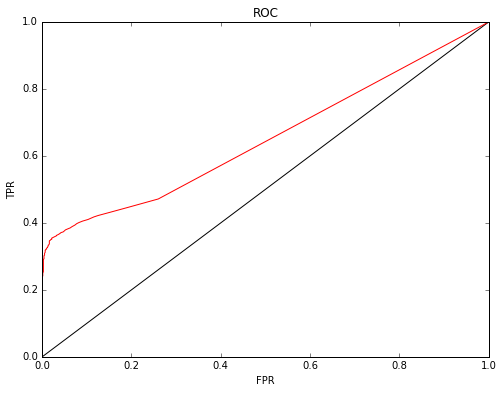

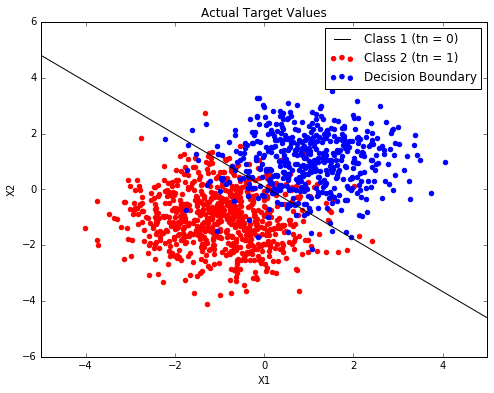

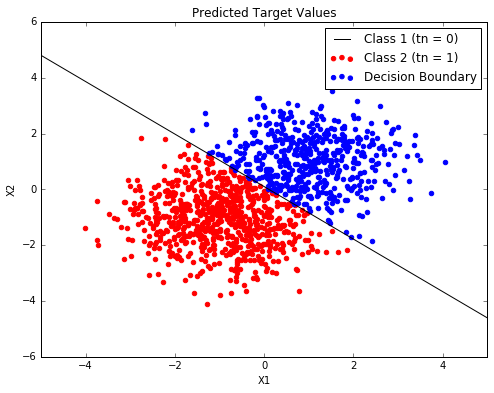


a > b Dataset (2 features):
threshold:  0.1
Number of 0's (class 1):  488
Number of 1's (class 2):  512
Accuracy: 60.8%

          Predicted 1  Predicted 0
                                  
Actual 1          120          392
Actual 0            0          488


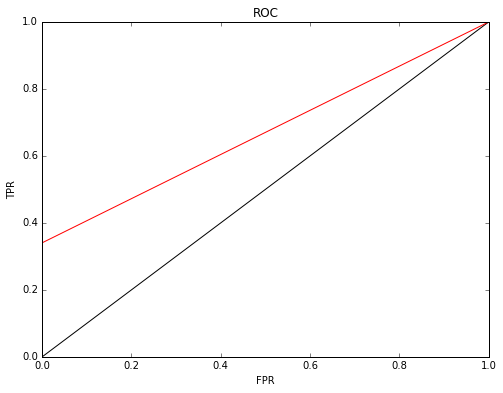

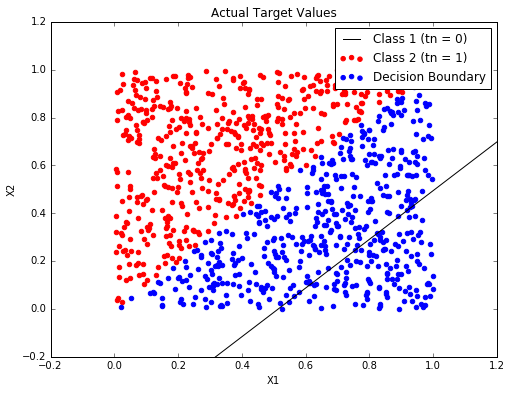

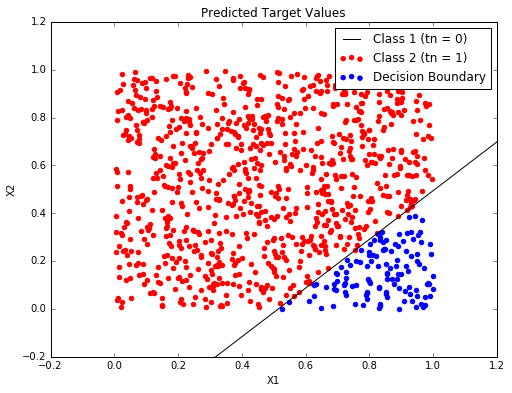


Haberman Dataset (3 features):
threshold:  0.1
Number of 0's (class 1):  225.0
Number of 1's (class 2):  81.0
Accuracy: 73.5%

          Predicted 1  Predicted 0
                                  
Actual 1            0           81
Actual 0            0          225


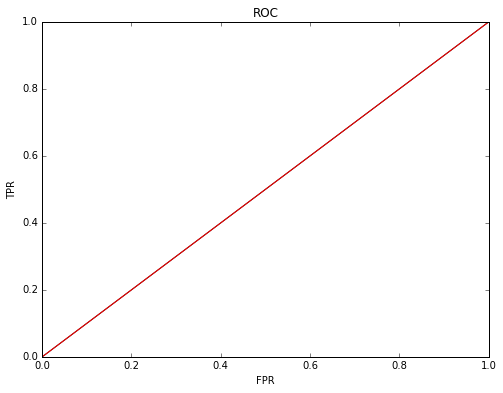


PID Dataset (8 features):
threshold:  0.1
Number of 0's (class 1):  500.0
Number of 1's (class 2):  268.0
Accuracy: 65.1%

          Predicted 1  Predicted 0
                                  
Actual 1            0          268
Actual 0            0          500


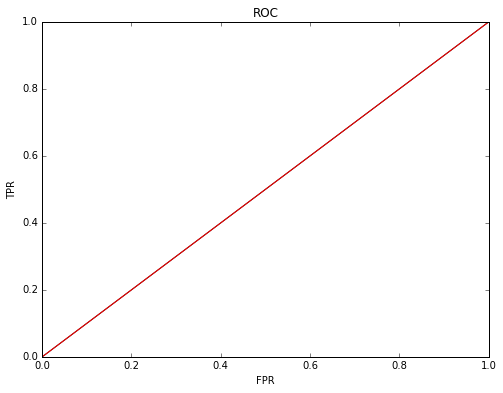

In [3]:
# Binary classification with full generative Gaussian model (P198, 4.2.1-4.2.2)

# Book-keeping:
# Data is nObservations-by-nFeatures (so each observation is a row vector)
# Mean vectors are column vectors of length nFeatures
# Covariance matrices are nFeatures-by-nFeatures

# Functions to perform maximum likelihood estimates for parameters
# ASSUMPTION: Class 1: tn = 0, Class 2: tn = 1 (the book has it flipped, P200)
# 4.75: Mean for class k
def classMean(X,Y,k):
    class_indices = np.where(Y == k)
    class_indices = class_indices[0]
        # Find the indices for the rows/observations that are of class k 
    #print Y[class_indices,:] #debug
    #print Y[class_indices,:].shape, X[class_indices,:].shape, class_indices.shape
    return np.transpose(np.mean(X[class_indices,:],axis=0))
        # mean along rows (mean of observations for each feature)
        # np.where returns indices as row vectors
        # Indexing using these will also return row vec, so take tranponse for col vec

# 4.79-4.80: Covariance for class k
def classCovariance(X,Y,k):
    class_indices = np.where(Y == k)
    class_indices = class_indices[0]
    return np.cov(X[class_indices,:],rowvar=False)
        # if rowvar is True, then each row is a variable, columns are observations
        # Since our columns are features, we make rowvar False
        
# 4.78: Weighted average for class covariances, for binary classification case
def binaryWeightedCovariance(X,Y):
    # Get row indices in X where corresponding Y's are of a certain class
    class1_indices = np.where(Y == 0)
    class2_indices = np.where(Y == 1)
    class1_indices = class1_indices[0]
    class2_indices = class2_indices[0]
    # Get number of observations for each class
    N1 = Y[class1_indices].shape[1]
    N2 = Y[class2_indices].shape[1]
    N = N1 + N2
    # Find convariances for each class
    S1 = classCovariance(X,Y,0)
    S2 = classCovariance(X,Y,1)
    # Find weighted coveriance
    return float(N1)/N*S1 + float(N2)/N*S2    
    
# 4.73: Prior class probability for class k (p(Ck))
def priorClassProbability(Y,k):
    N = Y.shape[0];
    Nk = Y[np.where(Y == k)].shape[1]
        # Return the length of the resulting vector that matches condition Y = k
        # Need to use shape[1] because a row vector is returned apparently
    return float(Nk)/N

# Use model to predict Y from X and compare to actual Y
# Debug flag to print out debug table
# Provide threshold to round sigmoid function
def gaussianGenerativeModel(X,Y,threshold=0.5,statsOn=True,debugOn=False):
    
    # Get means and covariance for class conditional densities
    mu1 = classMean(X,Y,0)
    mu2 = classMean(X,Y,1)
    cov = binaryWeightedCovariance(X,Y)

    # Find prior class probabilities using ML estimate
    pi1 = priorClassProbability(Y,0)
    pi2 = priorClassProbability(Y,1)

    # Find weights and bias parameters used to determine input to sigmoid ak
    # See P198, 4.66-4.67 for weight formulas for binary classification
    w1 = np.linalg.inv(cov)*(mu1-mu2)
    w2 = np.linalg.inv(cov)*(mu2-mu1)
    w1_0 = -float(1)/2*np.transpose(mu1)*np.linalg.inv(cov)*mu1 + \
            -float(1)/2*np.transpose(mu2)*np.linalg.inv(cov)*mu2 + \
            np.log(pi1/pi2)
    w2_0 = -float(1)/2*np.transpose(mu2)*np.linalg.inv(cov)*mu2 + \
            -float(1)/2*np.transpose(mu1)*np.linalg.inv(cov)*mu1 + \
            np.log(pi2/pi1)
        # Optionally cast these to float because result is a scalar nested within 1x1 matrices
    
    # See P199, 4.69-4.70 for weight formulas for K classes
    # Don't think we should use these for binary even though it should generalize
    """
    w1 = np.linalg.inv(cov)*(mu1)
    w2 = np.linalg.inv(cov)*(mu2)
    w1_0 = -float(1)/2*np.transpose(mu1)*np.linalg.inv(cov)*mu1 + \
            np.log(pi1)
    w2_0 = -float(1)/2*np.transpose(mu2)*np.linalg.inv(cov)*mu2 + \
            np.log(pi2)
    """
    
    # (Don't need this) Obtain parameters to input into sigmoid (ak)
    a1 = np.transpose(w1)*np.transpose(X) + w1_0
    a2 = np.transpose(w2)*np.transpose(X) + w2_0
    a1 = np.transpose(a1)
    a2 = np.transpose(a2)
    
    # Concatenate weights into one column vector
    w1 = np.concatenate((w1_0,w1),axis=0)
    w2 = np.concatenate((w2_0,w2),axis=0)

    # Make predictions for using training set to check for error
    # k=0: Class 1
    #Y_predict = predictY(X,w1,threshold,k=0) # doens't work
    Y_predict = predictY(X,w2,threshold,k=1)
    
    # Calculate prediction statistics
    (accuracy,contingency_table) = computePredictionStats(Y,Y_predict)

    # Print prediction statistics
    if statsOn:
        print 'threshold: ', threshold
        print 'Number of 0\'s (class 1): ', Y.shape[0]-np.sum(Y)
        print 'Number of 1\'s (class 2): ', np.sum(Y)
        """
        print 'mu1:\t', np.transpose(mu1)
        print 'mu2:\t', np.transpose(mu2)
        print 'cov:\t', cov
        print "pi:\t", pi1, pi2  # pi2 = 1-pi1
        print 'w1:\t', np.transpose(w1)
        print 'w2:\t', np.transpose(w2)
        print 'bias:', w1_0, w2_0
        """
        print ("Accuracy: %-.1f%%\n") % (accuracy)
        print contingency_table

    # Print debug stats
    if debugOn:
        print "Debug stats:"
        print ("%-10s %-15s %-15s %-15s %-10s %-10s %6s") % \
                ('Obs', 'a2', 'exp(-a2)', 'sigmoid(a2)', 'Y', 'Y_predict', 'Match?')
        for i in range(0, Y.shape[0]):
            print ("%-10d %-15.5f %-15.5f %-15.5f %-10.1s %-10.1s %6s") % \
                    (i+1,a2[i],np.exp(-a2[i]),sigmoid(a2[i]),int(Y[i]),int(Y_predict[i]),bool(Y[i]==Y_predict[i]))
                
    return (Y_predict,w2,accuracy)

# Go through thresholds, test the threshold that gives max accuracy
# Return prediction with max accuracy
def testThresholds(X,Y,debugOn=False):
    accuracy_list = []
    for threshold in range(0,10,1):
        (Y_tmp,w_tmp,accuracy) = gaussianGenerativeModel(X,Y,threshold=float(threshold)/10,statsOn=False)
        accuracy_list.append(accuracy)
    max_accuracy = max(accuracy_list)
    threshold_best = float(accuracy_list.index(max_accuracy))/10
    #print accuracy_list
    (Y_best,w_best,accuracy_best) = gaussianGenerativeModel(X,Y,threshold=threshold_best,debugOn=debugOn)
    return (Y_best,w_best,threshold_best,accuracy_best)

print 'Keene\'s Dataset (2 features):'
#(Y1_predict,w1,accuracy1) = gaussianGenerativeModel(X1,Y1,debugOn=False)
(Y1_predict,w1,threshold1,accuracy1) = testThresholds(X1,Y1,debugOn=False)
plotROC(X1,Y1,model='generativeModel')
plotActualVersusPredicted(X1,Y1,Y1_predict,w1,threshold=threshold1)#0.5)
print

print 'a > b Dataset (2 features):'
#(Y2_predict,w2,accuracy2) = gaussianGenerativeModel(X2,Y2)
(Y2_predict,w2,threshold2,accuracy2) = testThresholds(X2,Y2)
plotROC(X2,Y2,model='generativeModel')
plotActualVersusPredicted(X2,Y2,Y2_predict,w2,threshold=threshold2)#0.5)
print

print 'Haberman Dataset (3 features):'
#(Y3_predict,w3,accuracy3) = gaussianGenerativeModel(X3,Y3)
(Y3_predict,w3,threshold3,accuracy3) = testThresholds(X3,Y3)
plotROC(X3,Y3,model='generativeModel')
print

print 'PID Dataset (8 features):'
#(Y4_predict,w4,accuracy4) = gaussianGenerativeModel(X4,Y4)
(Y4_predict,w4,threshold4,accuracy4) = testThresholds(X4,Y4)
plotROC(X4,Y4,model='generativeModel')
print


Keene's Dataset (2 features):
IRLS stopped at iteration 2, (w_err_old,w_err_new) = (0.058,0.151)
Accuracy: 90.6%

          Predicted 1  Predicted 0
                                  
Actual 1          479           21
Actual 0           97          653


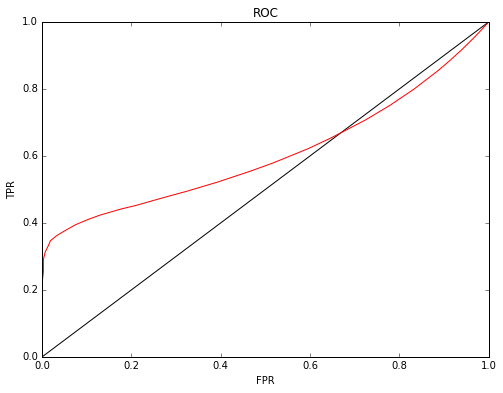

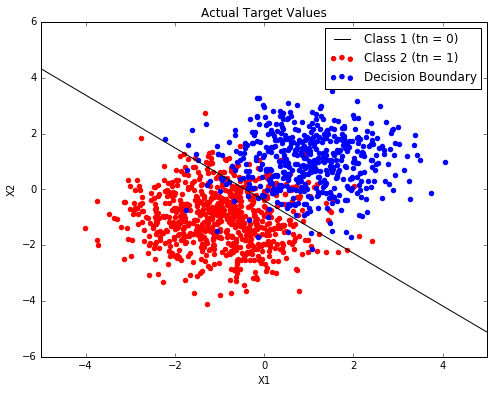

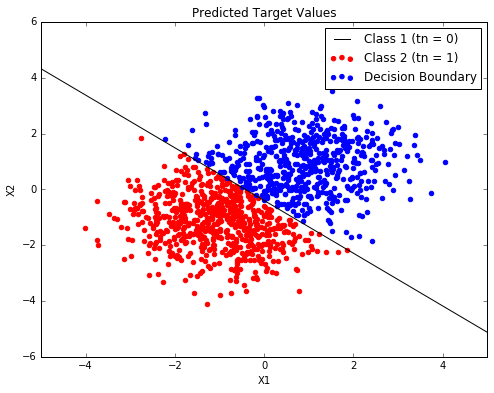


a > b Dataset (2 features):
IRLS stopped at iteration 2, (w_err_old,w_err_new) = (1.970,5.081)
Accuracy: 98.8%

          Predicted 1  Predicted 0
                                  
Actual 1          500           12
Actual 0            0          488


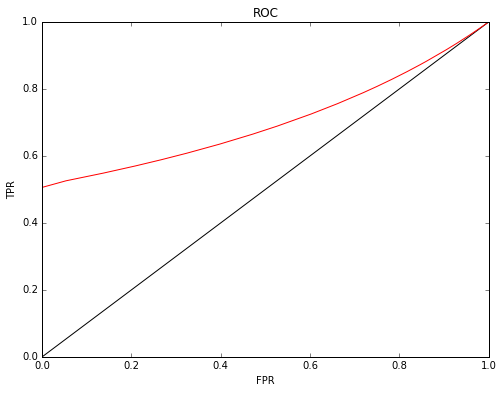

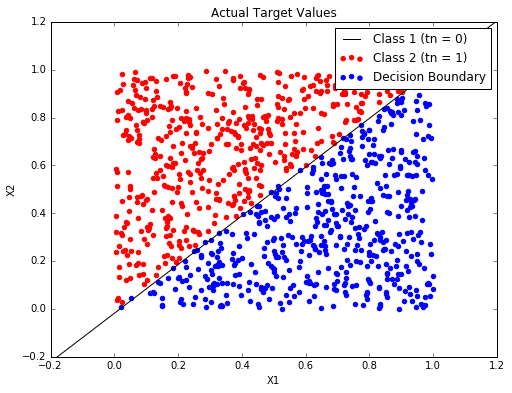

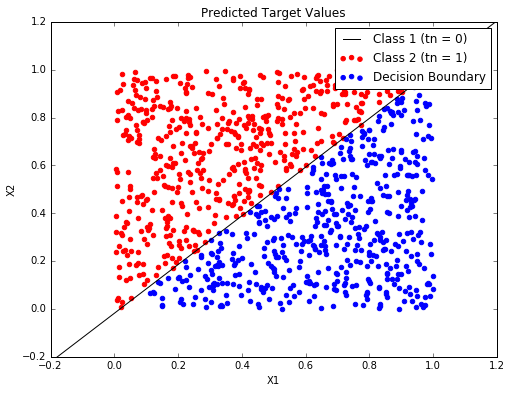


Haberman Dataset (3 features):
IRLS stopped at iteration 2, (w_err_old,w_err_new) = (0.027,0.073)
Accuracy: 72.2%

          Predicted 1  Predicted 0
                                  
Actual 1           44           37
Actual 0           48          177


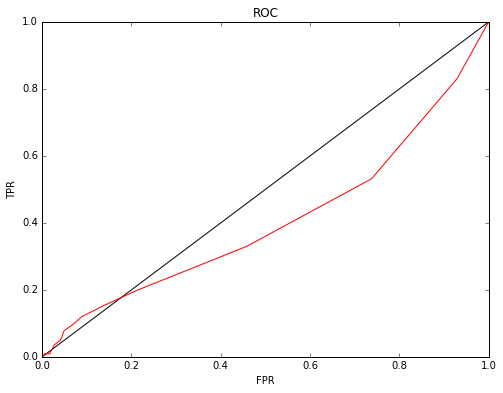


PID Dataset (8 features):
IRLS stopped at iteration 2, (w_err_old,w_err_new) = (1.470,3.920)
Accuracy: 74.7%

          Predicted 1  Predicted 0
                                  
Actual 1          216           52
Actual 0          142          358


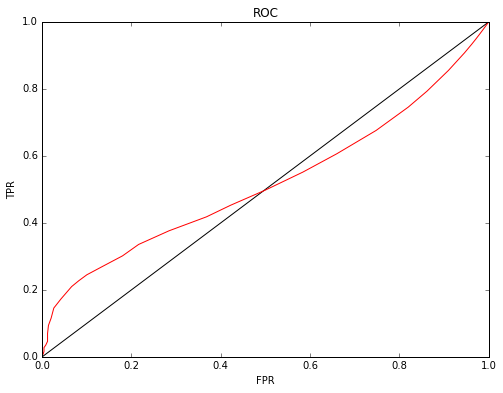

In [4]:
# Logistic regression using IRLS optimization and L1 penalty (P235, 4.3.2-4.3.3)
# According to textbook, this predicts class 1 (tn = 1) (class 2 is tn = 0)
# However, for some reason, when I run the algo it's as if class 1 is tn = 0, lol w/e
def logisticRegression(X,Y,reg='none',threshold=0.5,statsOn=True):
    
    nObservations = X.shape[0]
    nFeatures = X.shape[1]
    
    # Bias basis vector
    phi_0 = np.ones((nObservations,1))
    
    # Design matrix is [1,x0,x1,...,xn], nObservations-by-(nFeatures+1)
    phi = np.concatenate((phi_0,X),axis=1)
    
    # Target values are just the actual Y
    t = Y;
    
    # Initialize weights to 0's, nFeatures+1 weights to include bias
    w = np.asmatrix(np.zeros((nFeatures+1,1)))
    
    # Initialize predictions to 0's, since weights are 0 (w.T*phi = 0*phi = 0)
    y = np.asmatrix(np.zeros((nObservations,1)))

    # Iterative reweighted least squares
    currIter = 0
    nIter = 500
    w_error = float('inf')
        # initialize weight error to infinity
    w_error_threshold = 0.01
    while currIter < nIter:
                
        # Recalculate weight matrix R (P207, 4.98) for every iteration
        R = np.asmatrix(np.ones((nObservations,nObservations)))
        for n in range(0,nObservations):
            R[n,n] = y[n]*(1-y[n])
        
        # Newton-Raphson update equation (P208, 4.99-4.100)
        # phi: nObs-by-(nFeats+1), R: nObs-by-nObs
        # result of inv: (nFeats+1)-by-(nFeats+1)
        # result of multiply by phi.T: (nFeats+1)-by-nObs
        # y,t: nObs-by-1
        # w: (nFeats+1)-by-1
        #w_new = w - np.linalg.inv(phi.T*R*phi)*phi.T*(y-t) # same result
        z = phi*w - np.linalg.inv(R)*(y-t)
        if reg == 'none':
            w_new = np.linalg.inv(phi.T*R*phi)*phi.T*R*z
        
        # L1 Regularization using LARS
        elif reg == 'L1':
            continue
        
        # Calculate new squared error between new and old w, then replace old w with new
        w_error_new = np.sum(np.square(w_new-w))
        #print w_new,'\n',w,'\n',w_new-w,'\n',np.square(w_new-w), np.sum(np.square(w_new-w))
        #print 'Iteration:', currIter, 'w_error', w_error
        
        # Stop condition
        # Checking the weight errors throughout the iterations, I have found that the weight
        # errors themselves are converging rather than the weights, so the previous
        # stop condition that terminates the loop if the weight error is below a threshold won't
        # necessarily work. Thus, the new stop condition is that if the current error
        # exceeds the previous weight error (meaning there is a bigger gap between weights at 
        # this iteration compared to the previous iteration), the loop terminates. Since the
        # weight error is initialized at infinity, and everything is less than infinity, at least
        # one complete iteration is guaranteed so there won't be an incomplete solution.
        if w_error_new > w_error:
            if statsOn:
                print ("IRLS stopped at iteration %d, (w_err_old,w_err_new) = (%.3f,%.3f)") % (currIter+1,w_error,w_error_new)
            break
        
        # Replace weights and weight error
        w = w_new
        w_error = w_error_new
        
        # Make new prediction for y
        y = sigmoid(phi*w)
            # Assuming that w is nFeatures-by-1 and design matrix is nObservations-by-(nFeatures+1),
            # the book's formula on P206, 4.87 (w.T*phi) doesn't work, should be
            # design_matrix*w = (w.T*phi.T).T to achieve a y that is nObservations-by-1
        
        currIter += 1
        
    # Round probability, then invert because we're predicting class 1, tn = 0
    Y_predict = np.logical_not(np.greater(y,threshold))
    
    # Compute prediction statistics
    (accuracy,contingency_table) = computePredictionStats(Y,Y_predict)
    
    if statsOn:
        print ("Accuracy: %-.1f%%\n") % (accuracy)
        print contingency_table
    
    return (Y_predict,w,accuracy)


print 'Keene\'s Dataset (2 features):'
(Y1_predict,w1,accuracy1) = logisticRegression(X1,Y1,reg='none')
plotROC(X1,Y1,model='logisticRegression')
plotActualVersusPredicted(X1,Y1,Y1_predict,w1,threshold=0.5)
print

print 'a > b Dataset (2 features):'
(Y2_predict,w2,accuracy2) = logisticRegression(X2,Y2,reg='none')
plotROC(X2,Y2,model='logisticRegression')
plotActualVersusPredicted(X2,Y2,Y2_predict,w2,threshold=0.5)
print

print 'Haberman Dataset (3 features):'
(Y3_predict,w3,accuracy3) = logisticRegression(X3,Y3,reg='none')
plotROC(X3,Y3,model='logisticRegression')
print

print 'PID Dataset (8 features):'
(Y4_predict,w4,accuracy4) = logisticRegression(X4,Y4,reg='none')
plotROC(X4,Y4,model='logisticRegression')
print


Keene's Dataset (2 features):
Accuracy: 91.5%

          Predicted 1  Predicted 0
                                  
Actual 1          444           56
Actual 0           50          700


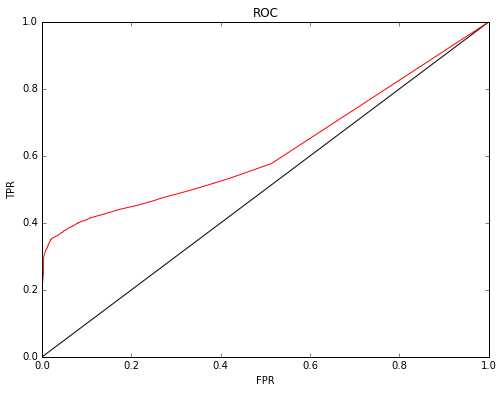

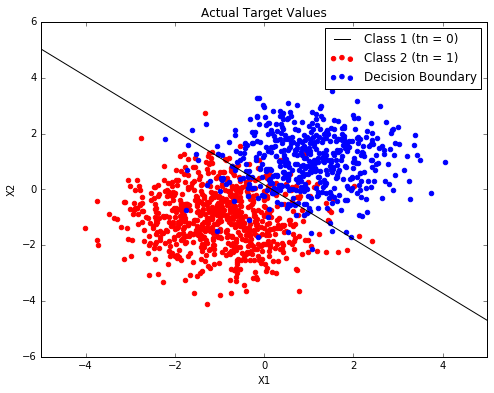

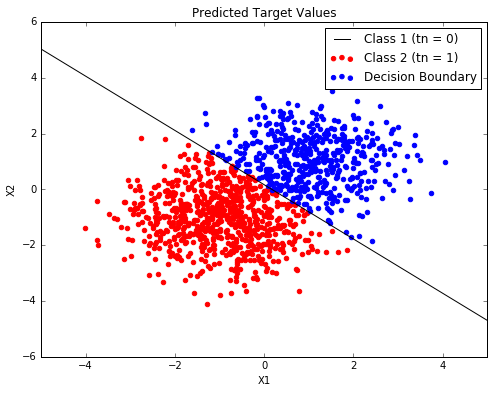


a > b Dataset (2 features):
Accuracy: 100.0%

          Predicted 1  Predicted 0
                                  
Actual 1          512            0
Actual 0            0          488


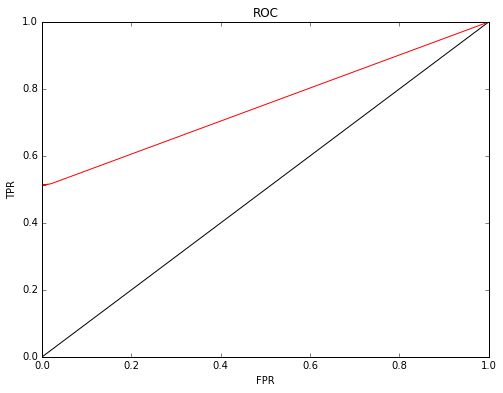

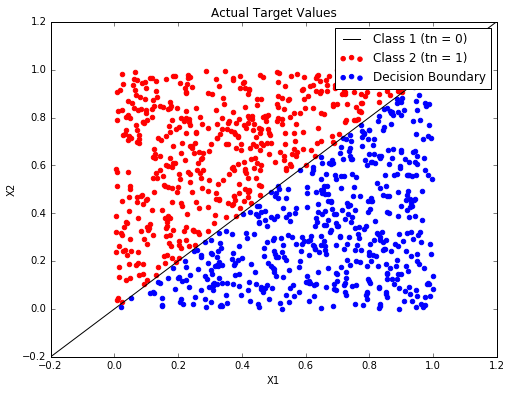

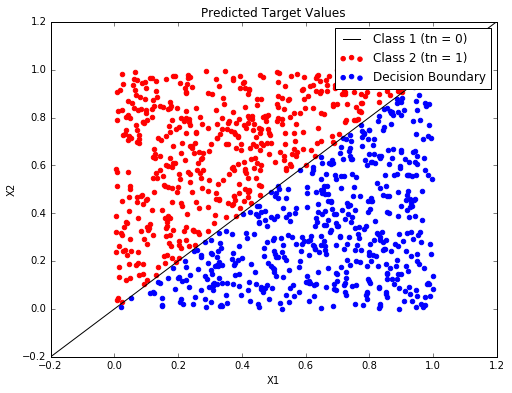


Haberman Dataset (3 features):
Accuracy: 74.8%

          Predicted 1  Predicted 0
                                  
Actual 1           14           67
Actual 0           10          215


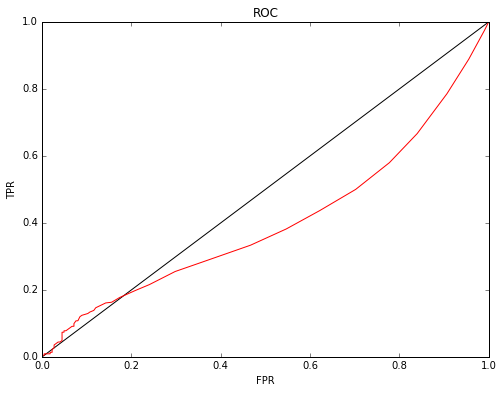


PID Dataset (8 features):
Accuracy: 78.3%

          Predicted 1  Predicted 0
                                  
Actual 1          156          112
Actual 0           55          445


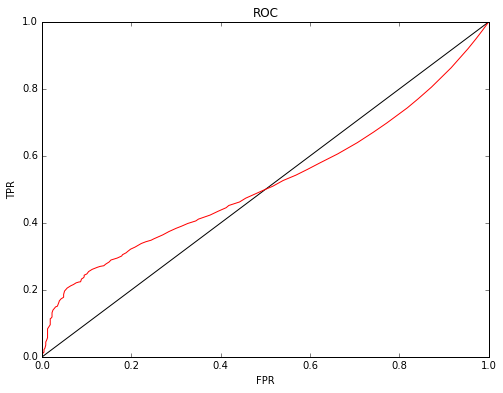

In [5]:
# Logistic regression using scikit-learn's libraries
def logisticRegression_sklearn(X,Y,threshold=0.5,statsOn=True):
    
    # Turn off regularization by making C really high
    clf = LogisticRegression(penalty='l1',C=1000,fit_intercept=True).fit(X,np.ravel(Y))
        # default tolerance: tol=0.0001
        # need to ravel Y because function likes to accept a 1D flattened array
    
    #print clf.intercept_, clf.coef_, clf.intercept_.shape, clf.coef_.shape
    w = (np.asmatrix(np.insert(clf.coef_,0,clf.intercept_))).T
        # clf_coef: feature coefficients i.e. weight vector, 1-by-nFeatures
        # clf_intercept: bias, w0
        # bias is inserted at beginning of weight vector (index 0)
    
    # Predict targets
    # sklearn predicts tn = 1 (Class 2 in our case), so don't invert results
    Y_predict = predictY(X,w,threshold,k=1)
    
    # Compute prediction statistics
    (accuracy,contingency_table) = computePredictionStats(Y,Y_predict)
    
    if statsOn:
        print ("Accuracy: %-.1f%%\n") % (accuracy)
        print contingency_table
    
    return (Y_predict,w,accuracy)

print 'Keene\'s Dataset (2 features):'
(Y1_predict,w1,accuracy1) = logisticRegression_sklearn(X1,Y1)
plotROC(X1,Y1,model='logisticRegression_sklearn')
plotActualVersusPredicted(X1,Y1,Y1_predict,w1,threshold=0.5)
print

print 'a > b Dataset (2 features):'
(Y2_predict,w2,accuracy2) = logisticRegression_sklearn(X2,Y2)
plotROC(X2,Y2,model='logisticRegression_sklearn')
plotActualVersusPredicted(X2,Y2,Y2_predict,w2,threshold=0.5)
print

print 'Haberman Dataset (3 features):'
(Y3_predict,w3,accuracy3) = logisticRegression_sklearn(X3,Y3)
plotROC(X3,Y3,model='logisticRegression_sklearn')
print

print 'PID Dataset (8 features):'
(Y4_predict,w4,accuracy4) = logisticRegression_sklearn(X4,Y4)
plotROC(X4,Y4,model='logisticRegression_sklearn')
print
